# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\email\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
data_path = r"D:\Python\kaoculator\\"

# Create Training Set

We're using the SQUAD dataset for question and answering

In [4]:
import json
data = json.load(open(f"{data_path}train-v2.0.json", "r"))

In [5]:
data['data'][0]['paragraphs'][0].keys()

dict_keys(['qas', 'context'])

In [6]:
data['data'][0]['paragraphs'][0]

{'qas': [{'question': 'When did Beyonce start becoming popular?',
   'id': '56be85543aeaaa14008c9063',
   'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
   'is_impossible': False},
  {'question': 'What areas did Beyonce compete in when she was growing up?',
   'id': '56be85543aeaaa14008c9065',
   'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
   'is_impossible': False},
  {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
   'id': '56be85543aeaaa14008c9066',
   'answers': [{'text': '2003', 'answer_start': 526}],
   'is_impossible': False},
  {'question': 'In what city and state did Beyonce  grow up? ',
   'id': '56bf6b0f3aeaaa14008c9601',
   'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
   'is_impossible': False},
  {'question': 'In which decade did Beyonce become famous?',
   'id': '56bf6b0f3aeaaa14008c9602',
   'answers': [{'text': 'late 1990s', 'answer_start': 276}],
   'is_impossible': False},
  {'q

In [7]:
processed_data = []
for sample in data['data']:
    sample = sample['paragraphs']
    for paragraph in sample:
        for qa_pairs in paragraph['qas']:
            for answer in qa_pairs['answers']:
                entry = "<|startoftext|>" + paragraph['context'] + " " + qa_pairs['question'] + "<|answer|>" + answer['text'] + "<|endoftext|>"
                processed_data.append(entry)
print(len(processed_data))

86821


In [8]:
class QADataset(Dataset):
    def __init__(self, path:str, tokenizer, max_length=768):
        self.data = json.load(open(path, "r"))

        self.X = []
        self.Y = []
        for sample in self.data['data']:
            sample = sample['paragraphs']
            for paragraph in sample:
                for qa_pairs in paragraph['qas']:
                    for answer in qa_pairs['answers']:
                        context_question = "<|startoftext|>" + paragraph['context'] + " " + qa_pairs['question'] + "<|answer|>"
                        self.X.append(context_question)
                        self.Y.append(answer['text'])
                        
        
        indices = np.random.permutation(5000) #change to number of samples you want 
        self.X, self.Y = np.array(self.X), np.array(self.Y)
        self.X, self.Y = self.X[indices], self.Y[indices]
        self.X, self.Y = list(self.X), list(self.Y)
        
        print(self.X[0])

        self.X_encoded = tokenizer(self.X, truncation=True, padding="max_length", return_tensors="pt", max_length=max_length)
        self.Y_encoded = tokenizer(self.Y, truncation=True, padding="max_length", return_tensors="pt", max_length=max_length)
        self.input_ids = self.X_encoded['input_ids']
        self.attention_mask = self.X_encoded['attention_mask']
        self.label_ids = self.Y_encoded['input_ids']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx], self.label_ids[idx])

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

100%|██████████| 5000/5000 [00:03<00:00, 1520.23it/s]
C:\Users\email\AppData\Local\Temp/ipykernel_17516/4274368390.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<AxesSubplot: ylabel='Density'>

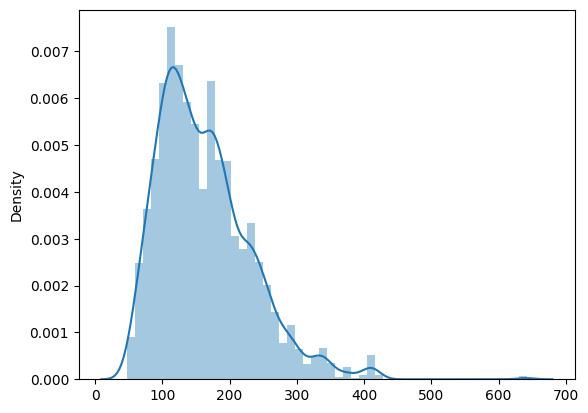

In [9]:
from tqdm import tqdm
doc_lengths = []

for d in tqdm(processed_data[:5000]):

    # get rough token count distribution
    tokens = nltk.word_tokenize(d)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
count = 0
sns.distplot(doc_lengths)

In [10]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [11]:
np.average(doc_lengths)

162.7892

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer.add_tokens(["<|answer|>"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [13]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [14]:
batch_size = 1

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [15]:
dataset = QADataset(f"{data_path}train-v2.0.json", tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

<|startoftext|>Executive vice governor Wei Hong confirmed on November 21, 2008 that more than 90,000 people in total were dead or missing in the earthquake. He stated that 200,000 homes had been rebuilt, and 685,000 were under reconstruction, but 1.94 million households were still without permanent shelter. 1,300 schools had been reconstructed, with initial relocation of 25 townships, including Beichuan and Wenchuan, two of the most devastated areas. The government spent $441 billion on relief and reconstruction efforts. Who spoke about the dead and missing people on November 21, 2008?<|answer|>
4,500 training samples
  500 validation samples


In [16]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [17]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [18]:
# some parameters I cooked up that work reasonably well

epochs = 50
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 10000

In [19]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [20]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [21]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [22]:
# MODEL_PATH = f'{data_path}model_save/gpt2-base.pt'

# checkpoint = torch.load(MODEL_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [23]:
#torch.cuda.empty_cache()
from tqdm import tqdm
MODEL_PATH = f'{data_path}model_save/gpt2-qa2.pt'

total_t0 = time.time()

training_stats = []

model = model.to(device)

# try:
#     checkpoint = torch.load(MODEL_PATH)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     loss = checkpoint['loss']
# except:
#     epoch = 0
epoch = 0

for epoch_i in range(epoch, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[2].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, #you're basically training the model to be able to output your inputs
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

            # Create output directory if needed
            if not os.path.exists(f"{data_path}/model_save"):
                os.makedirs(f"{data_path}/model_save")

            print("Saving model to %s" % MODEL_PATH)

            torch.save({
              'epoch': epoch_i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
            }, MODEL_PATH)

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[2].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 50 ========
Training...


100%|██████████| 4500/4500 [16:09<00:00,  4.64it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:24

======== Epoch 2 / 50 ========
Training...


100%|██████████| 4500/4500 [13:55<00:00,  5.38it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:23

======== Epoch 3 / 50 ========
Training...


100%|██████████| 4500/4500 [15:58<00:00,  4.69it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:25

======== Epoch 4 / 50 ========
Training...


100%|██████████| 4500/4500 [14:39<00:00,  5.12it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:24

======== Epoch 5 / 50 ========
Training...


100%|██████████| 4500/4500 [14:38<00:00,  5.12it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:25

======== Epoch 6 / 50 ========
Training...


100%|██████████| 4500/4500 [18:06<00:00,  4.14it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:33

======== Epoch 7 / 50 ========
Training...


100%|██████████| 4500/4500 [15:28<00:00,  4.85it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:22

======== Epoch 8 / 50 ========
Training...


100%|██████████| 4500/4500 [13:26<00:00,  5.58it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:22

======== Epoch 9 / 50 ========
Training...


100%|██████████| 4500/4500 [13:26<00:00,  5.58it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:22

======== Epoch 10 / 50 ========
Training...


100%|██████████| 4500/4500 [14:08<00:00,  5.30it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:24

======== Epoch 11 / 50 ========
Training...


100%|██████████| 4500/4500 [14:57<00:00,  5.02it/s]  



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:24

======== Epoch 12 / 50 ========
Training...


100%|██████████| 4500/4500 [15:41<00:00,  4.78it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:35

======== Epoch 13 / 50 ========
Training...


100%|██████████| 4500/4500 [17:41<00:00,  4.24it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:28

======== Epoch 14 / 50 ========
Training...


100%|██████████| 4500/4500 [17:49<00:00,  4.21it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:29

======== Epoch 15 / 50 ========
Training...


100%|██████████| 4500/4500 [16:14<00:00,  4.62it/s]



Running Validation...
  Validation Loss: 0.04
  Validation took: 0:00:26

======== Epoch 16 / 50 ========
Training...


 10%|█         | 457/4500 [01:43<15:14,  4.42it/s]


KeyboardInterrupt: 

In [24]:
if not os.path.exists(f"{data_path}/model_save"):
    os.makedirs(f"{data_path}/model_save")

print("Saving model to %s" % MODEL_PATH)

torch.save({
  'epoch': 5,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss,
}, MODEL_PATH)

Saving model to D:\Python\kaoculator\\model_save/gpt2-qa2.pt


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Generate Text

In [25]:
def predict(model, prompt):
    model.eval()

    prompt = "<|startoftext|>" + prompt + "<|answer|>"

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    sample_outputs = model.generate(
                                    **inputs, 
                                    #bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    # top_k=50, 
                                    max_length = 300,
                                    top_p=0.1, 
                                    num_return_sequences=3
                                    )

    for i, sample_output in enumerate(sample_outputs):
        print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

In [26]:
predict(model, "Why is machine learning so hard")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Why is machine learning so hard <|answer|>


1: Why is machine learning so hard <|answer|>


2: Why is machine learning so hard <|answer|>




These aren't bad at all!
